# Bank Marketing Classification

In this part of the assignment we want to do a classification task using PyTorch on bank marketing dataset.

#Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

#Load Dataset
Here, you should download and load the dataset. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [2]:
#TODO
path = 'bank-full.csv'
data = pd.read_csv(path, sep=';')
data = data.dropna()
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#Normalize data
normalize numerical data.

In [3]:
continuous_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
scaler = StandardScaler()
encoder = LabelEncoder()
data[continuous_cols] = scaler.fit_transform(data[continuous_cols])
data = pd.get_dummies(data, columns=categorical_cols)
data['y'] = encoder.fit_transform(data['y'])

# Create Data Loader
create data loader for pytorch

In [4]:
#TODO
X = data.drop('y', axis=1)
y = data['y']
X = X.astype(np.float32)
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#Model
define your model in here

In [5]:
class BankMarketingNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

#Train your model
Define `criterion` and `optimizer`.
Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [6]:
#TODO
EPOCHS = 250
LEARNING_RATE = 0.0002

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model = BankMarketingNet(X_train.shape[1]).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

train_losses = []
val_losses = []
for epoch in range(EPOCHS):

    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(X_batch)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item() * len(X_batch)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    if val_loss == min(val_losses):
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch: {epoch+1}/{EPOCHS},\tTraining Loss: {train_loss:0.20f},\tValidation Loss: {val_loss:0.20f}')

Epoch: 1/250,	Training Loss: 0.68032081089109075478,	Validation Loss: 0.63803724209256629241
Epoch: 2/250,	Training Loss: 0.59198793248336400996,	Validation Loss: 0.53944729159453674860
Epoch: 3/250,	Training Loss: 0.48837947064749320791,	Validation Loss: 0.43848908884260040519
Epoch: 4/250,	Training Loss: 0.39832099551236233026,	Validation Loss: 0.36813217563007921695
Epoch: 5/250,	Training Loss: 0.34600581327942298016,	Validation Loss: 0.33448236193891067725
Epoch: 6/250,	Training Loss: 0.32125745070883282573,	Validation Loss: 0.31505567329801625887
Epoch: 7/250,	Training Loss: 0.30381144199022930286,	Validation Loss: 0.29743464052136614484
Epoch: 8/250,	Training Loss: 0.28740635900768851663,	Validation Loss: 0.28017611048491070092
Epoch: 9/250,	Training Loss: 0.27172883066540931551,	Validation Loss: 0.26481221818971412141
Epoch: 10/250,	Training Loss: 0.25836189431900874469,	Validation Loss: 0.25247990941677017629
Epoch: 11/250,	Training Loss: 0.24819563715839196294,	Validation Loss

### Visualize Loss plot

Using the arrays that you have (from previous task in the above section), visualize Loss plot (train and validation together)

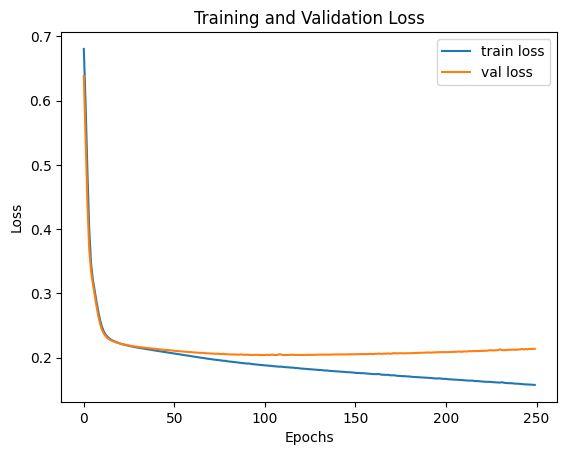

In [7]:
#TODO
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have).

In [8]:
#TODO
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(model(X_batch).cpu().numpy())
        loss = criterion(model(X_batch), y_batch)
        test_loss += loss.item() * len(X_batch)
test_loss /= len(test_loader.dataset)

y_true = np.array(y_true).reshape(-1)
y_pred = np.array(y_pred).reshape(-1)
y_pred = np.where(y_pred > 0.5, 1, 0)

accuracy = (y_true == y_pred).mean()
recall = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
precision = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
f1 = 2 * precision * recall / (precision + recall)

print(f'Accracy:\t{accuracy}\nRecall:\t\t{recall}\nPrecision:\t{precision}\nF1:\t\t{f1}\nTest Loss:\t{test_loss}')

Accracy:	0.9061152272475949
Recall:		0.5087076076993584
Precision:	0.6394009216589862
F1:		0.5666156202143952
Test Loss:	0.21041460908034015
